In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib import cm
from matplotlib.patches import Circle
from astropy import units as u
from astropy import constants as const
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()
import sympy as sm

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import scipy as sp
import multiprocessing as mp

import time
start_total = time.time()

from plasma_jet_class import sieplasmajet


import warnings
warnings.filterwarnings('ignore')

In [2]:
zl = 0.2; zs = 1.2

Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)

print('Dl: ',Dl); print('Ds: ',Ds); print('Dls: ',Dls)
print('G: ',(const.G).value ,(const.G).unit)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
print('rho_crit :',rho_crit)
c_light = (const.c).to(u.cm/u.second)
print('c_light :', c_light)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
print('r0:', r0)
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E_g: ',theta_E_SIS() ,'arcsec')

theta_E_g = theta_E_SIS()
elipt = eta = 0.3
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

Dl:  705.4019455128785 Mpc
Ds:  1760.3796178766652 Mpc
Dls:  1375.6149203241862 Mpc
G:  6.6743e-11 m3 / (kg s2)
rho_crit : 1.0483397591328813e-26 kg / m3
c_light : 29979245800.0 cm / s
r0: 10.0 kpc
scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E_g:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [3]:
theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [4]:
A = 2.00744300029693
B = 1.5887225542022732
C = 1.4308204791467736

phi = np.linspace(0,2*np.pi, 3000)

In [5]:
eta = 0.3
n0 = 300./(u.cm)**(3)

theta_E_g = theta_E_SIS().value
theta_0_num = theta_0.value

deltab_10 = 0
deltab_20 = 0
delta_rs = .07

In [6]:
x = np.arange(30,200,1)
y = []
for i in x: 
    nu = i * u.MHz
    omega = nu*(1.+zl)*2*np.pi

    psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
                *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

    psi0_plasma_num = psi0_plasma.value
    sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    y_tmp = sie_plasma.d2psi0_dr2
    y.append(y_tmp)

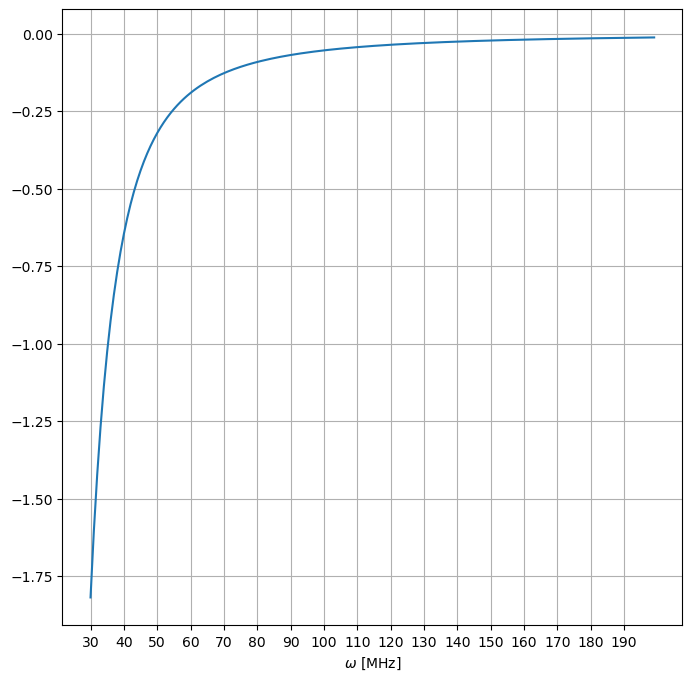

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax.plot(x,y)
ax.set_xticks(np.arange(30, 200, 10))
ax.set_xlabel(r'$\omega$ [MHz]')
ax.set_ylabel('')

plt.grid()
plt.show()

In [8]:
dbh = 27.4*u.Mpc
separation = 500*u.pc

In [9]:
angularseparation = separation/dbh

In [10]:
(angularseparation.decompose())*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())

<Quantity 3.76395632>

In [11]:
Dl

<Quantity 705.40194551 Mpc>

In [12]:
((separation/Dl).decompose())*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())

<Quantity 0.14620374>

In [13]:
(Dl*(5.6e-3)*4.84814e-6).to('pc')

<Quantity 19.15136937 pc>

In [14]:
nu = 300* u.MHz
omega = nu*(1.+zl)*2*np.pi

psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value

In [15]:
def f(r):
    tmp_f = r - theta_E_g + C/r * (r/B/theta_0_num)**C * psi0_plasma_num*50* np.exp(-(r/B/theta_0_num)**C)
    return tmp_f

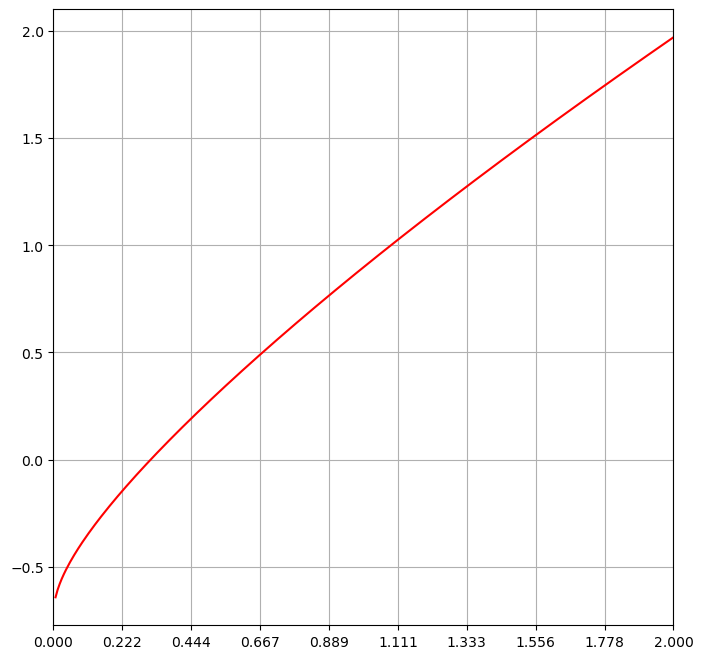

In [16]:

from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()


figz = plt.figure(figsize=(8,8))
axz = figz.gca()
axz.set_xticks(np.linspace(0, 2, 10))
plt.grid()
axz.set_xlim([0, 2])

r = np.linspace(0,2,300)
axz.plot(r,f(r), color = 'red')
plt.show()

In [17]:
phi = 0
def f(r):
    psi = theta_E_g*r*np.sqrt(1.-eta*np.cos(2.*phi)) + \
              psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C) 
    dpsi = theta_E_g*r*(np.sqrt( 1. - eta*np.cos(2*phi)) - 1)
    psi0 = theta_E_g*r + psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C)
    psi_plasma = psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C)
    ddpsi_dr = theta_E_g*(np.sqrt( 1. - eta*np.cos(2*phi)) - 1)
    ddpsi_dphi = theta_E_g*r*eta*np.sin(2.*phi)/np.sqrt(1.-eta*np.cos(2.*phi))
    d2psi0_dr2 = psi_plasma * ( - C*(C-1)/r**2*(r/B/theta_0_num)**C + (C/r*(r/B/theta_0_num)**C)**2 )
    return d2psi0_dr2

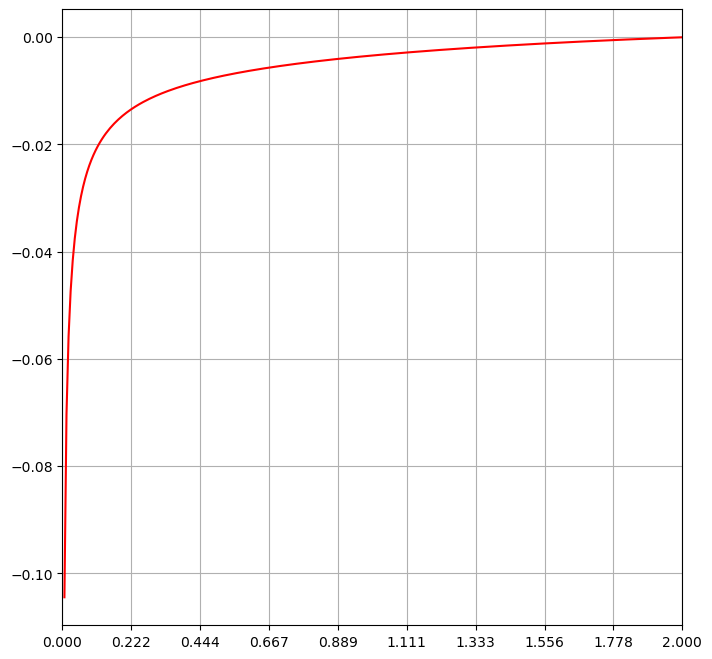

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.linspace(0, 2, 10))
plt.grid()
ax.set_xlim([0, 2])

r = np.linspace(0,2,300)
ax.plot(r,f(r), color = 'red')
plt.show()

In [19]:
phi = 0
def f(r):
    psi = theta_E_g*r*np.sqrt(1.-eta*np.cos(2.*phi)) + \
              psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C) 
    dpsi = theta_E_g*r*(np.sqrt( 1. - eta*np.cos(2*phi)) - 1)
    psi0 = theta_E_g*r + psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C)
    psi_plasma = psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C)
    ddpsi_dr = theta_E_g*(np.sqrt( 1. - eta*np.cos(2*phi)) - 1)
    ddpsi_dphi = theta_E_g*r*eta*np.sin(2.*phi)/np.sqrt(1.-eta*np.cos(2.*phi))
    d2psi0_dr2 = psi_plasma * C/r**2 *(r/B/theta_0)**C *(1.+C*(  (r/B/theta_0)**C-1)  )
#     d2psi0_dr2 = psi_plasma * C/r**2 *(r/B/theta_0_num)**C *(1.+C*( (r/B/theta_0_num)**(C-1)))
    return d2psi0_dr2

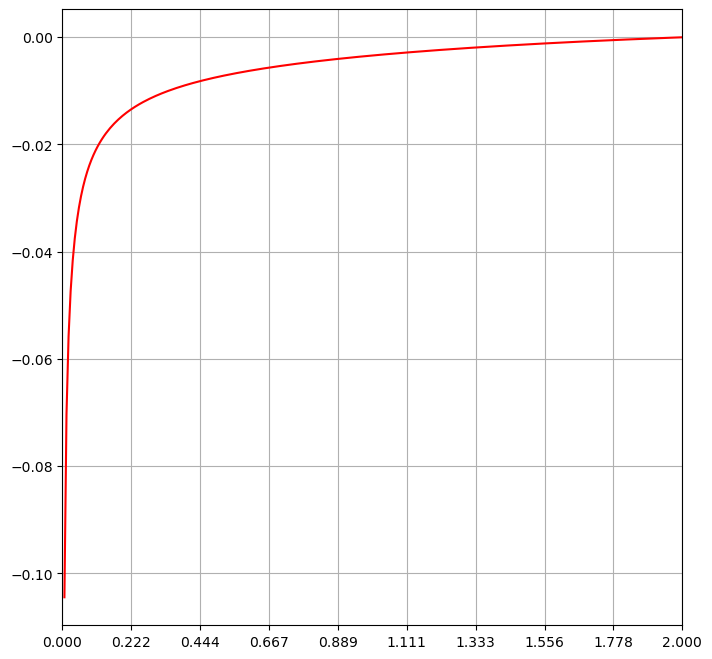

In [20]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.linspace(0, 2, 10))
plt.grid()
ax.set_xlim([0, 2])

r = np.linspace(0,2,300)
ax.plot(r,f(r), color = 'red')
plt.show()

In [21]:
atuple = (1,2,3)
btuple = 4,5,6

In [22]:
btuple

(4, 5, 6)

In [23]:
class tomi(object):
    def __init__(self,x):
        self.x = x
        aa = 7
    def var(self):
        return aa

In [24]:
tomi1 = tomi(5)

In [25]:
tomi1.x

5

In [26]:
tomi1.var

<bound method tomi.var of <__main__.tomi object at 0x7fad11775e20>>

In [27]:
def probe(x, y, z = ()):
    return 1.9*x + 2.5*y + 3.7*z

In [28]:
probe(1,(2),(3))

18.0

In [29]:
probe(1, z = 3, y = 2)

18.0

In [30]:
probe(1,3,2)

16.8

In [31]:
for phi in sie_plasma.phi:
    print(phi)

0.0
0.0020950934668821563
0.004190186933764313
0.006285280400646469
0.008380373867528625
0.010475467334410783
0.012570560801292938
0.014665654268175093
0.01676074773505725
0.018855841201939408
0.020950934668821565
0.02304602813570372
0.025141121602585876
0.027236215069468033
0.029331308536350187
0.031426402003232344
0.0335214954701145
0.03561658893699666
0.037711682403878816
0.03980677587076097
0.04190186933764313
0.04399696280452528
0.04609205627140744
0.048187149738289595
0.05028224320517175
0.05237733667205391
0.054472430138936066
0.056567523605818223
0.058662617072700374
0.06075771053958253
0.06285280400646469
0.06494789747334685
0.067042990940229
0.06913808440711115
0.07123317787399332
0.07332827134087547
0.07542336480775763
0.07751845827463978
0.07961355174152195
0.0817086452084041
0.08380373867528626
0.08589883214216841
0.08799392560905056
0.09008901907593272
0.09218411254281487
0.09427920600969704
0.09637429947657919
0.09846939294346135
0.1005644864103435
0.10265957987722565
0.

In [32]:
r2 = [1 , 2 , 3]

In [33]:
np.array(r2)*4.

array([ 4.,  8., 12.])

In [34]:
sie_plasma.phi

array([0.00000000e+00, 2.09509347e-03, 4.19018693e-03, ...,
       6.27899512e+00, 6.28109021e+00, 6.28318531e+00])

In [35]:
sie_plasma.probe()

AttributeError: 'sieplasmajet' object has no attribute 'probe'

In [ ]:
def tt(x):
    y = x**2
    print(y)
    return 5

In [ ]:
tt(2)*2

In [ ]:
sie_plasma.critic()

In [ ]:
sie_plasma.psi_plasma

In [ ]:
r5 = np.array([1,2,3])

In [ ]:
r5.append(6)

In [ ]:
t1 = time.time()
s1 = []
for i in range(0,1000000,1):
    s1.append(i)
s1 = np.array(s1)
t2 = time.time()
t2-t1

In [ ]:
t1 = time.time()
s2 = np.array([])
for i in range(0,1000000,1):
    np.append(s2,i)
t2 = time.time()
t2-t1

In [ ]:
s1

In [ ]:
s2

In [ ]:
ssssssaaaaaaaaaaasdwwwewd

In [ ]:
a, b, c, d = sm.symbols('a b c d')

In [ ]:
tom = sm.expand((a+b+c+d)**2)

In [ ]:
tom

In [ ]:
ztomi = 0.00428
Dtomi = cosmo.angular_diameter_distance(ztomi)   

In [ ]:
Dtomi2 = cosmo.comoving_distance(ztomi)
Dtomi3 = cosmo.comoving_transverse_distance(ztomi)
Dtomi4 = cosmo.luminosity_distance(ztomi)

In [ ]:
Dtomi

In [ ]:
(9.4e9*u.lyr).to(u.Mpc)

In [42]:
((0.6*u.arcsec).to('rad'))*Ds

<Quantity 0.00512074 Mpc rad>

In [43]:
((20*u.arcsec).to('rad'))*18.9*u.Mpc

<Quantity 0.0018326 Mpc rad>

In [ ]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

In [ ]:
lens_model_list = ['SIE']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)

In [ ]:
kwargs = {'theta_E':theta_E_num.value, 'x1':0, 'y1':0}
kwargs_lens_list = [kwargs]

In [ ]:
def image_position(source):
    x_s, y_s,light = source
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_s, sourcePos_y=y_s, min_distance=0.05, search_window=5, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    light_pre = []
    for k in range(len(x_pre)):
        light_pre = np.append(light_pre,light)
    return x_pre, y_pre, light_pre

def main(x1,x2,x3):
    start_p = time.time()
    x = x1
    y = x2
    l = x3
    
    with mp.Pool(mp.cpu_count()-1) as pool:
        out = pool.map(image_position, zip(x,y,l))
        
        xx = []; yy = []; ll = []
        for i in range(len(out)):
            x = out[i][0]
            xx.append(x)
            y = out[i][1]
            yy.append(y)
            l = out[i][2]
            ll.append(l)
        xx = np.concatenate(xx, axis=0)
        yy = np.concatenate(yy, axis=0)
        ll = np.concatenate(ll, axis=0)
    end_p = time.time()
    pool.close()
    print('time: ',(end_p-start_p)/60.,' minutes')
        
    return xx, yy, ll

In [ ]:
x_image, y_image, light_image = main(mesh_x,mesh_y,mesh_light)